/Users/pavelmanyakin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[*********************100%%**********************]  1 of 1 completed


                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2020-01-02  101.360001  102.209999  101.019997  102.199997  97.793648   
2020-01-03  100.589996  102.000000  100.309998  101.919998  97.525696   
2020-01-06  100.949997  101.839996  100.870003  101.830002  97.439568   
2020-01-07  101.809998  102.739998  100.809998  101.779999  97.391716   
2020-01-08  101.309998  102.139999  100.849998  101.550003  97.171661   
...                ...         ...         ...         ...        ...   
2024-05-08   93.120003   93.639999   92.730003   93.589996  93.589996   
2024-05-09   93.639999   93.980003   93.010002   93.389999  93.389999   
2024-05-10   93.070000   93.139999   90.879997   90.940002  90.940002   
2024-05-13   91.269997   92.769997   91.150002   92.720001  92.720001   
2024-05-14   92.989998   94.339996   92.599998   92.790001  92.790001   

              Volume  
Date                  
2020

[216/300] Loss: 99.52402400970459
[217/300] Loss: 99.0723648071289
[218/300] Loss: 98.66585540771484
[219/300] Loss: 98.29892921447754
[220/300] Loss: 97.97014331817627
[221/300] Loss: 97.66359806060791
[222/300] Loss: 97.37636947631836
[223/300] Loss: 97.08444690704346
[224/300] Loss: 96.78600883483887
[225/300] Loss: 96.46864414215088
[226/300] Loss: 96.12824440002441
[227/300] Loss: 95.76477241516113
[228/300] Loss: 95.35949516296387
[229/300] Loss: 94.92811393737793
[230/300] Loss: 94.46040916442871
[231/300] Loss: 93.95252323150635
[232/300] Loss: 93.42019748687744
[233/300] Loss: 92.84864330291748
[234/300] Loss: 92.2540168762207
[235/300] Loss: 91.64632987976074
[236/300] Loss: 91.02827262878418
[237/300] Loss: 90.3962812423706
[238/300] Loss: 89.77071475982666
[239/300] Loss: 89.1540060043335
[240/300] Loss: 88.55284786224365
[241/300] Loss: 87.97557163238525
[242/300] Loss: 87.4305477142334
[243/300] Loss: 86.91241550445557
[244/300] Loss: 86.43533134460449
[245/300] Loss: 86.

[90/165] LossD: 9.685514688491821 LossG:4.872164845466614
[91/165] LossD: 9.702110528945923 LossG:4.85722279548645
[92/165] LossD: 9.682863712310791 LossG:4.870742380619049
[93/165] LossD: 9.686458945274353 LossG:4.870419919490814
[94/165] LossD: 9.702611207962036 LossG:4.85542768239975
[95/165] LossD: 9.698060035705566 LossG:4.859232544898987
[96/165] LossD: 9.687755227088928 LossG:4.873283207416534
[97/165] LossD: 9.690515279769897 LossG:4.86939936876297
[98/165] LossD: 9.696364641189575 LossG:4.862558364868164
[99/165] LossD: 9.701050996780396 LossG:4.857352614402771
[100/165] LossD: 9.694724559783936 LossG:4.86669135093689
[101/165] LossD: 9.698328137397766 LossG:4.862343847751617
[102/165] LossD: 9.676605701446533 LossG:4.882068574428558
[103/165] LossD: 9.698110461235046 LossG:4.859906315803528
[104/165] LossD: 9.678171396255493 LossG:4.87799459695816
[105/165] LossD: 9.699998617172241 LossG:4.859090745449066
[106/165] LossD: 9.696399927139282 LossG:4.862520813941956
[107/165] Lo

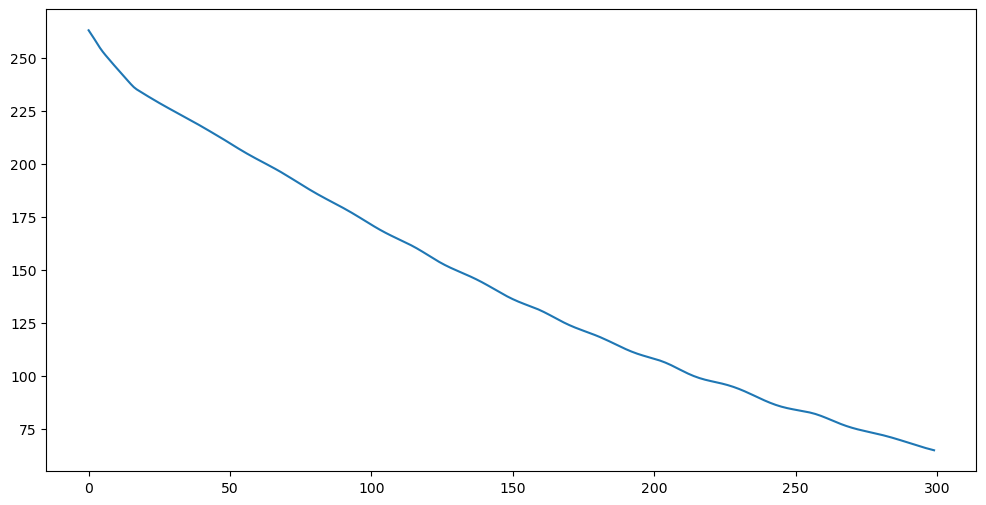

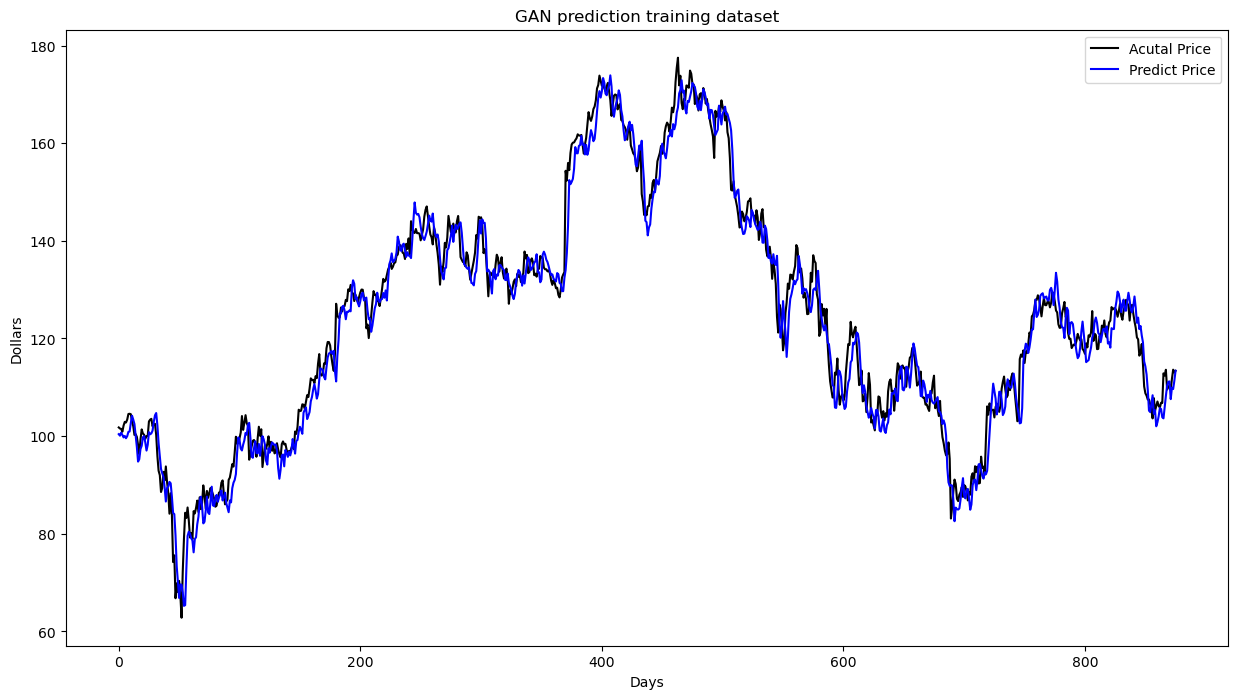

In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
# Define the ticker symbol
ticker_symbol = 'NKE'

data = yf.download(ticker_symbol, start="2020-01-01", end=dt.date.today())

print(data)
data['y'] = data['Close'].copy()

x = data.iloc[:, :6].values
y = data.iloc[:, 6].values


split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([6, 100, 100, 100, 10], 10)
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(16).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())
plt.figure(figsize=(15, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('Dollars')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [2]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import matplotlib.pyplot as plt

end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=365)
data = yf.download('NKE', start=start_date, end=end_date, interval='1h')
data['Close'] = data['Close'].fillna(method='ffill')

x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values
y = data['Close'].values
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(x)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

def create_dataset(x, time_steps=24):
    x_new = []
    for i in range(time_steps, len(x)):
        x_new.append(x[i-time_steps:i])
    return np.array(x_new)

time_steps = 24
x_new = create_dataset(x_scaled, time_steps)


[*********************100%%**********************]  1 of 1 completed
/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_80674/3632445471.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'] = data['Close'].fillna(method='ffill')


In [5]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=365)
data = yf.download('NKE', start=start_date, end=end_date, interval='1h')
data['Close'] = data['Close'].ffill()

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

if not data.empty:
    x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values
    y = data['Close'].values
    x_scaled = x_scaler.fit_transform(x)
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    def create_dataset(x, time_steps=24):
        x_new = []
        for i in range(time_steps, len(x)):
            x_new.append(x[i-time_steps:i])
        return np.array(x_new)

    time_steps = 24
    x_new = create_dataset(x_scaled, time_steps)
    dataset = TensorDataset(torch.from_numpy(x_new).float(), torch.from_numpy(y_scaled[time_steps:]).float())
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize models
    generator = Generator(input_dim=time_steps, hidden_dim=128, output_dim=time_steps)
    discriminator = Discriminator(input_dim=time_steps)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Train the GAN
    epochs = 200
    for epoch in range(epochs):
        for x_batch, _ in train_loader:
            real_data = x_batch.view(-1, time_steps)
            real_labels = torch.ones(real_data.size(0), 1)
            fake_labels = torch.zeros(real_data.size(0), 1)

            discriminator.zero_grad()
            outputs = discriminator(real_data)
            real_loss = criterion(outputs, real_labels)
            noise = torch.randn(real_data.size(0), time_steps)
            fake_data = generator(noise)
            outputs = discriminator(fake_data)
            fake_loss = criterion(outputs, fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            generator.zero_grad()
            noise = torch.randn(real_data.size(0), time_steps)
            fake_data = generator(noise)
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')
else:
    print("No data available for model training.")


[*********************100%%**********************]  1 of 1 completed


Epoch [1/200], d_loss: 1.3342313766479492, g_loss: 0.6394335627555847
Epoch [2/200], d_loss: 1.4157373905181885, g_loss: 0.85242760181427
Epoch [3/200], d_loss: 1.3272420167922974, g_loss: 0.8787505030632019
Epoch [4/200], d_loss: 1.3335638046264648, g_loss: 0.7094878554344177
Epoch [5/200], d_loss: 1.280855417251587, g_loss: 0.7423585653305054
Epoch [6/200], d_loss: 1.3962314128875732, g_loss: 0.6869157552719116
Epoch [7/200], d_loss: 1.3141546249389648, g_loss: 0.8032658100128174
Epoch [8/200], d_loss: 1.326016902923584, g_loss: 0.6927121877670288
Epoch [9/200], d_loss: 1.3827388286590576, g_loss: 0.7225873470306396
Epoch [10/200], d_loss: 1.382076621055603, g_loss: 0.7390198707580566
Epoch [11/200], d_loss: 1.3536505699157715, g_loss: 0.6650741696357727
Epoch [12/200], d_loss: 1.3884027004241943, g_loss: 0.7475548386573792
Epoch [13/200], d_loss: 1.3763599395751953, g_loss: 0.6924213767051697
Epoch [14/200], d_loss: 1.3921750783920288, g_loss: 0.6343017220497131
Epoch [15/200], d_lo

Epoch [118/200], d_loss: 1.403601884841919, g_loss: 0.666583776473999
Epoch [119/200], d_loss: 1.272338628768921, g_loss: 0.6326674818992615
Epoch [120/200], d_loss: 1.356285810470581, g_loss: 0.743739664554596
Epoch [121/200], d_loss: 1.406592607498169, g_loss: 0.8491953611373901
Epoch [122/200], d_loss: 1.2561519145965576, g_loss: 0.7675225138664246
Epoch [123/200], d_loss: 1.4483518600463867, g_loss: 0.6370627880096436
Epoch [124/200], d_loss: 1.3534767627716064, g_loss: 0.7616245746612549
Epoch [125/200], d_loss: 1.4181933403015137, g_loss: 0.6770104169845581
Epoch [126/200], d_loss: 1.3845250606536865, g_loss: 0.6950997710227966
Epoch [127/200], d_loss: 1.3766722679138184, g_loss: 0.676257848739624
Epoch [128/200], d_loss: 1.3833184242248535, g_loss: 0.6712290644645691
Epoch [129/200], d_loss: 1.4044724702835083, g_loss: 0.7513290643692017
Epoch [130/200], d_loss: 1.3777098655700684, g_loss: 0.7311647534370422
Epoch [131/200], d_loss: 1.3857663869857788, g_loss: 0.7212211489677429

In [6]:
generator.eval()
noise = torch.randn(1, time_steps)
generated_data = generator(noise)
predicted_prices = y_scaler.inverse_transform(generated_data.detach().numpy().reshape(-1, 1))

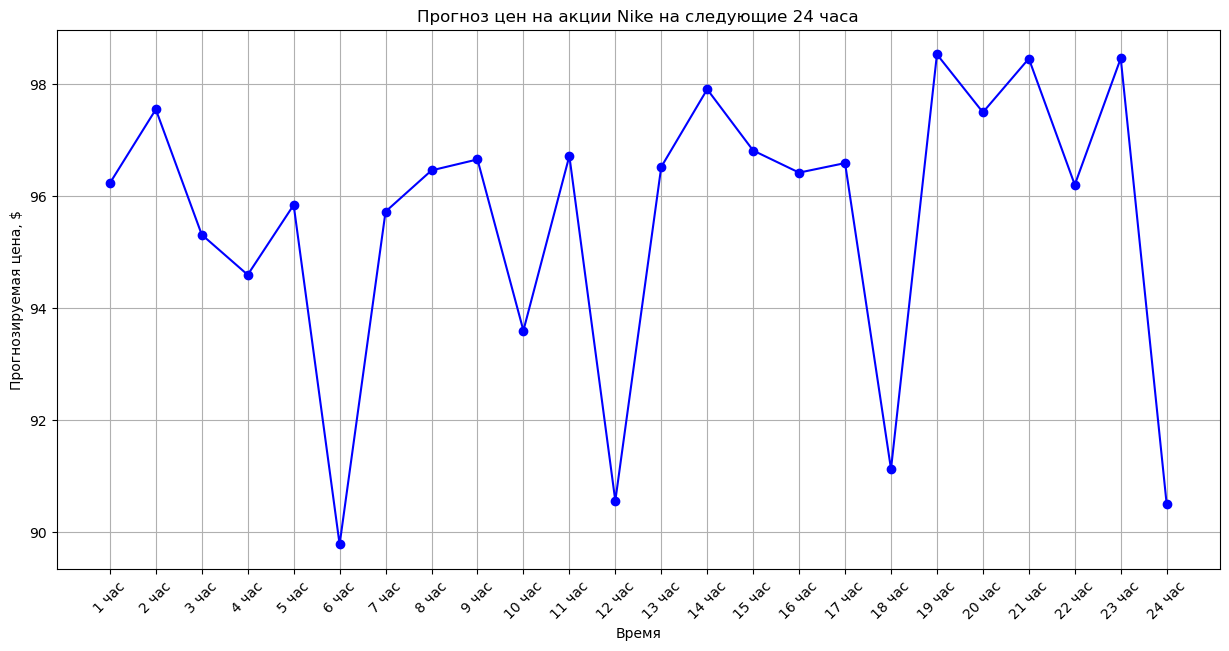

In [10]:
import matplotlib.pyplot as plt

hours = [f"{i+1} час" for i in range(24)]

plt.figure(figsize=(15, 7))
plt.plot(hours, predicted_prices.flatten(), marker='o', linestyle='-', color='blue')
plt.title('Прогноз цен на акции Nike на следующие 24 часа')
plt.xlabel('Время')
plt.ylabel('Прогнозируемая цена, $')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
